In [ ]:
# Cell 1: Imports and Data Loading (Warnings Addressed & Modules Imported)

import pandas as pd
import numpy as np
import os
import logging
import warnings # Import the warnings library
import sys # For path manipulation
import json # For saving/loading model

# Attempt to import TqdmWarning to filter it specifically
try:
    from tqdm import TqdmWarning
    warnings.filterwarnings("ignore", category=TqdmWarning) # Suppress Tqdm warnings
except ImportError:
    pass # If tqdm isn't installed or TqdmWarning isn't exposed, ignore this filtering

# --- Prophet and Metrics Imports ---
try:
    from prophet import Prophet
    from prophet.serialize import model_to_json, model_from_json # Add serializer imports
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
except ImportError as e:
     logging.error(f"Prophet or scikit-learn not installed? Error: {e}")
     logging.error("Please run: pip install prophet scikit-learn")
     raise

# --- Plotting Imports ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Project Modules Imports ---
# Add project root to path to allow importing project modules
try:
    NOTEBOOK_DIR = os.path.dirname(__file__)
    PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..'))
    logging.info(f"Project root determined using __file__: {PROJECT_ROOT}")
except NameError:
    # Fallback if __file__ is not defined (e.g., interactive session, some notebook environments)
    # Assume the current working directory is the 'notebook' directory and go up one level
    current_dir = os.path.abspath('.')
    logging.warning(f"__file__ not defined. Assuming current directory is notebook dir: {current_dir}")
    PROJECT_ROOT = os.path.abspath(os.path.join(current_dir, '..'))
    logging.info(f"Project root derived by going up one level: {PROJECT_ROOT}")
    # Verify if the 'data' directory exists from this derived root
    if not os.path.exists(os.path.join(PROJECT_ROOT, 'data')):
         logging.error(f"Derived project root assumption seems incorrect. 'data' directory not found at {os.path.join(PROJECT_ROOT, 'data')}. Check CWD.")
         raise NotADirectoryError("Could not reliably determine project root from CWD.")
# Add root to sys.path
if PROJECT_ROOT not in sys.path:
     sys.path.insert(0, PROJECT_ROOT)
     logging.info(f"Added project root to sys.path: {PROJECT_ROOT}")

# Import necessary functions from project modules
try:
    from src.api_integration.client import get_current_aqi_for_city # Needed for real-time adjustment
    logging.info("Successfully imported project module 'src.api_integration.client'.")
except ModuleNotFoundError:
    logging.error("Could not import project modules. Ensure PROJECT_ROOT is correct and src structure exists.")
    raise
except ImportError as e:
     logging.error(f"Error importing project module: {e}")
     raise

# --- Logging Configuration ---
# Ensure logger is set up (can be configured multiple times, but basicConfig sets it once)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - [%(levelname)s] - %(message)s')

# --- General Configuration ---
DATA_FILENAME = 'Master_AQI_Dataset.csv'
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'Post-Processing', 'CSV_Files', DATA_FILENAME)
TARGET_CITY = 'Delhi' # Start with one city

# --- Load Data ---
logging.info(f"Loading data from: {DATA_PATH}")
if not os.path.exists(DATA_PATH):
    logging.error(f"Data file not found: {DATA_PATH}")
    raise FileNotFoundError(f"Could not find data file at {DATA_PATH}")

try:
    # Load CSV *without* parsing dates initially
    df_master = pd.read_csv(DATA_PATH)
    logging.info(f"Raw data loaded successfully. Shape: {df_master.shape}")

    # --- Explicit Date Parsing ---
    # Specify the EXACT format based on previous error: dd/mm/yy
    date_format = '%d/%m/%y'
    logging.info(f"Attempting to parse 'Date' column with format: {date_format}")
    df_master['Date'] = pd.to_datetime(df_master['Date'], format=date_format)
    logging.info("'Date' column parsed successfully to datetime objects.")

except ValueError as ve:
     logging.error(f"Error parsing 'Date' column with format '{date_format}'. Check if all dates match this format. Error: {ve}")
     raise
except Exception as e:
    logging.error(f"Failed during data loading or initial date parsing: {e}")
    raise

# --- Reconstruct 'City' Column (Only if necessary) ---
if 'City' not in df_master.columns:
    logging.info("Reconstructing 'City' column from City_... columns...")
    city_columns = [col for col in df_master.columns if col.startswith('City_')]
    if not city_columns:
        logging.error("CRITICAL: No 'City_' columns found. Cannot filter by city.")
        raise ValueError("Cannot proceed without city information.")
    else:
        def get_city_name(row):
            for city_col in city_columns:
                if row[city_col] > 0:
                    return city_col.replace('City_', '')
            return 'Unknown'
        df_master['City'] = df_master.apply(get_city_name, axis=1)
        logging.info("Finished reconstructing 'City' column.")
else:
    logging.info("'City' column already exists.")


# --- Prepare Data for Prophet ---
logging.info(f"Preparing data for city: {TARGET_CITY}")
city_df = df_master[df_master['City'] == TARGET_CITY].copy()

if city_df.empty:
    logging.error(f"No data found for city: {TARGET_CITY}")
    raise ValueError(f"No data available for {TARGET_CITY}")

# Select and rename columns for Prophet: 'ds' (Date), 'y' (AQI)
prophet_df = city_df[['Date', 'AQI']].rename(columns={'Date': 'ds', 'AQI': 'y'})

# Ensure 'ds' is datetime (should be from pd.to_datetime above, but double-check)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Handle missing values in 'y' (e.g., using forward fill then backward fill)
initial_nan_count = prophet_df['y'].isnull().sum()
if initial_nan_count > 0:
    logging.warning(f"Found {initial_nan_count} missing AQI values ('y') for {TARGET_CITY}. Applying ffill then bfill.")
    prophet_df['y'] = prophet_df['y'].ffill() # Forward fill first
    prophet_df['y'] = prophet_df['y'].bfill() # Backward fill remaining NaNs (e.g., at the start)

    # Final check if any NaNs couldn't be filled
    if prophet_df['y'].isnull().any():
         logging.error(f"Could not fill all missing AQI values for {TARGET_CITY}. Investigate data.")
         raise ValueError(f"Unfillable missing AQI values for {TARGET_CITY}")

# Sort by date (Prophet generally expects sorted data)
prophet_df = prophet_df.sort_values(by='ds')

logging.info(f"Data prepared for Prophet. Shape: {prophet_df.shape}")
print("\n--- Prepared Data (First 5 rows) ---")
print(prophet_df.head())
print("\n--- Prepared Data (Last 5 rows) ---")
print(prophet_df.tail())
print(f"\nTime range: {prophet_df['ds'].min()} to {prophet_df['ds'].max()}")

2025-04-24 20:26:05,947 - [WARNING] - root - 2011935904.py:43 - __file__ not defined. Assuming current directory is notebook dir: /Users/apple/Personal_Files/Codes/BreatheEasy/notebook

--- Prepared Data (First 5 rows) ---
             ds      y
5107 2018-01-01  406.0
5108 2018-01-02  418.0
5109 2018-01-03  382.0
5110 2018-01-04  366.0
5111 2018-01-05  390.0

--- Prepared Data (Last 5 rows) ---
             ds      y
7642 2024-12-27  353.0
7643 2024-12-28  139.0
7644 2024-12-29  225.0
7645 2024-12-30  173.0
7646 2024-12-31  283.0

Time range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00


In [16]:
# Cell 2: Train/Validation Split and Improved Model Training

# --- Define Split Point ---
split_date_str = '2024-01-01'
split_date = pd.to_datetime(split_date_str)
logging.info(f"Splitting data at: {split_date_str}")

# Check data range relative to split date
last_data_date = prophet_df['ds'].max()
if last_data_date < split_date:
    logging.warning(f"Split date {split_date_str} is after the last data point ({last_data_date.date()}). Validation set will be empty.")
    train_df = prophet_df.copy() # Use all data for training
    validation_df = pd.DataFrame(columns=['ds', 'y']) # Empty validation set
else:
    train_df = prophet_df[prophet_df['ds'] < split_date].copy()
    validation_df = prophet_df[prophet_df['ds'] >= split_date].copy()

# Log training and validation set details
train_start = train_df['ds'].min().date() if not train_df.empty else 'N/A'
train_end = train_df['ds'].max().date() if not train_df.empty else 'N/A'
logging.info(f"Training set shape: {train_df.shape}, Date range: {train_start} to {train_end}")

val_start = validation_df['ds'].min().date() if not validation_df.empty else 'N/A'
val_end = validation_df['ds'].max().date() if not validation_df.empty else 'N/A'
logging.info(f"Validation set shape: {validation_df.shape}, Date range: {val_start} to {val_end}")

if validation_df.empty:
     logging.warning("Validation set is empty. Cannot evaluate model performance properly on unseen future data.")

# --- Instantiate and Fit IMPROVED Prophet Model ---
logging.info("Instantiating Improved Prophet model (Multiplicative Seasonality, Adjusted Priors)...")

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative', # CHANGED: Use multiplicative seasonality
    changepoint_prior_scale=0.1, # INCREASED: Allow more flexibility in trend changes (default 0.05)
    seasonality_prior_scale=10.0 # Default: 10.0 - Standard flexibility for seasonality
)

# Add specific Indian holidays
try:
    # Note: Holidays might interact differently with multiplicative seasonality
    model.add_country_holidays(country_name='IN')
    logging.info("Added country holidays for India.")
except Exception as e:
     logging.warning(f"Could not add country holidays for 'IN'. Error: {e}")


logging.info(f"Fitting Improved Prophet model to training data for {TARGET_CITY}...")
try:
    # Fit the model using the training data
    model.fit(train_df)
    logging.info("Improved model fitting complete.")
except Exception as e:
    logging.error(f"Error during improved model fitting: {e}")
    raise

# Display completion message
print(f"\nImproved Prophet model trained for {TARGET_CITY} using data up to {train_end}.")

/Users/apple/Personal_Files/Codes/BreatheEasy/venv/lib/python3.13/site-packages/holidays/countries/india.py:176: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)
20:21:17 - cmdstanpy - INFO - Chain [1] start processing


2025-04-24 20:21:17,605 - [INFO] - cmdstanpy - model.py:2058 - Chain [1] start processing


20:21:17 - cmdstanpy - INFO - Chain [1] done processing


2025-04-24 20:21:17,822 - [INFO] - cmdstanpy - model.py:2115 - Chain [1] done processing

Improved Prophet model trained for Delhi using data up to 2023-12-31.



--- Forecast Dataframe Sample (Tail) ---
            ds        yhat  yhat_lower  yhat_upper
361 2024-12-27  322.143949  239.208296  404.070228
362 2024-12-28  319.420084  232.518313  399.896562
363 2024-12-29  316.672935  230.223877  400.700956
364 2024-12-30  314.186270  227.359723  403.530717
365 2024-12-31  315.440185  232.161778  395.187680

--- Evaluation Dataframe Sample (Actual vs Forecast) ---
          ds      y        yhat
0 2024-01-01  346.0  335.869164
1 2024-01-02  340.0  336.810853
2 2024-01-03  341.0  337.778471
3 2024-01-04  377.0  337.319997
4 2024-01-05  333.0  331.867471

--- Evaluation Metrics (Improved Model) ---
Mean Absolute Error (MAE):      40.65
Mean Squared Error (MSE):       2926.83
Root Mean Squared Error (RMSE): 54.10
Mean Absolute Percentage Error (MAPE): 21.71%


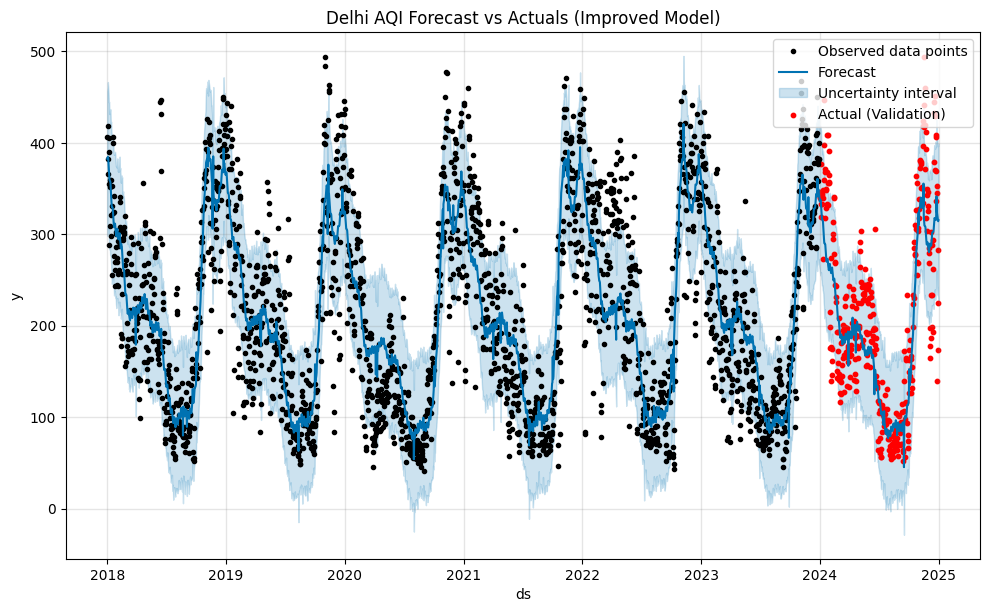

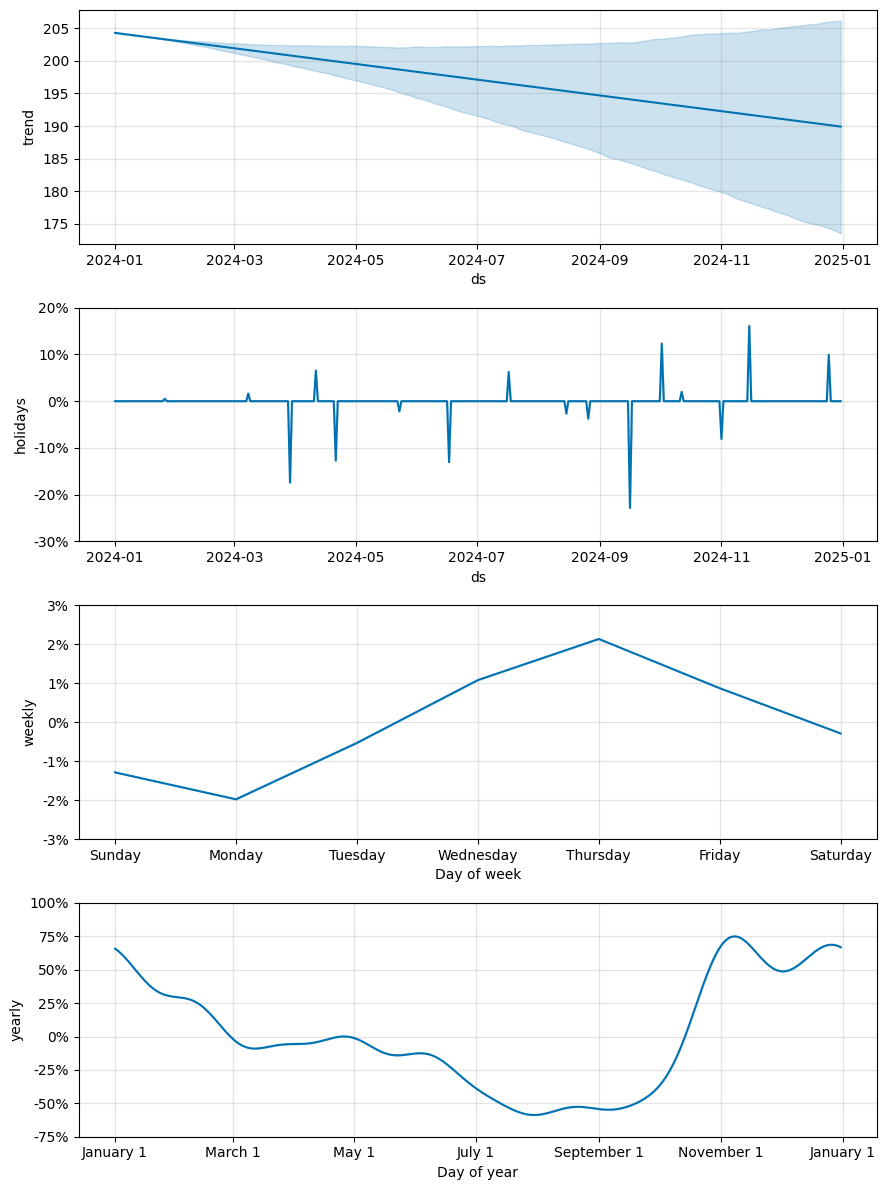

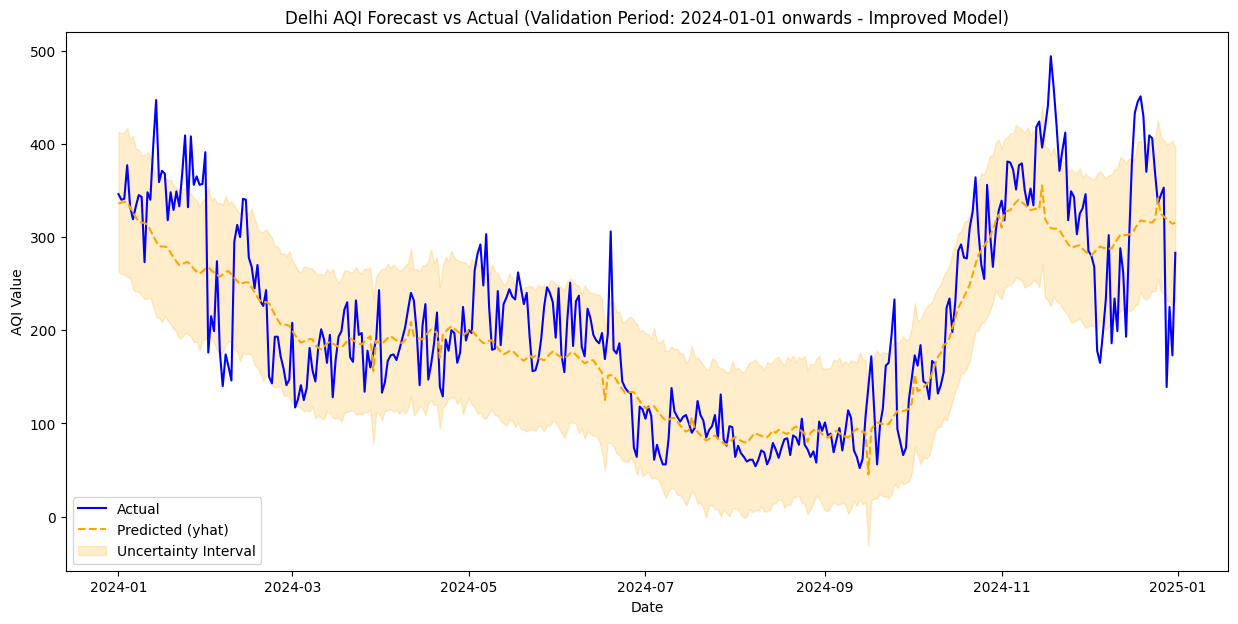


Improved model evaluation complete.


In [ ]:
# Cell 3: Make Predictions and Evaluate IMPROVED Model

# --- Create Future DataFrame ---
# We need dates covering the validation period (and potentially beyond if needed later)
logging.info(f"Making future dataframe for validation period (Length: {len(validation_df)} days)")


if not train_df.empty:
    predict_start_date = train_df['ds'].max() + pd.Timedelta(days=1)
else: # Handle case where training data might be empty (unlikely here)
    predict_start_date = validation_df['ds'].min() if not validation_df.empty else pd.Timestamp('today')

if not validation_df.empty:
    num_validation_periods = len(validation_df)
    future_dates = model.make_future_dataframe(periods=num_validation_periods, include_history=False) # Predict only future
    # Ensure the dates align correctly if prediction starts later than expected
    future_dates = future_dates[future_dates['ds'] >= predict_start_date]
else:
     logging.warning("Validation DataFrame is empty, cannot create future dates for evaluation.")
     future_dates = pd.DataFrame(columns=['ds']) # Empty dataframe

if not future_dates.empty:
     logging.info(f"Future dataframe created for prediction. Range: {future_dates['ds'].min().date()} to {future_dates['ds'].max().date()}")
else:
     logging.warning("Future dates dataframe is empty. Cannot proceed with prediction.")


# --- Generate Forecast ---
# Only proceed if we have future dates to predict for
if not future_dates.empty:
    logging.info("Generating forecast using the IMPROVED trained model...")
    try:
        # --- Placeholder for adding FUTURE regressors ---
        # If the model was trained with regressors:
        # Add the forecasted values for those regressors to future_dates here.
        # Example: future_dates['temp'] = [forecasted_temps_for_validation_period]
        # --- End Placeholder ---

        # Use the improved model to predict values for the future dates
        forecast = model.predict(future_dates)
        logging.info("Forecast generation complete.")
        print("\n--- Forecast Dataframe Sample (Tail) ---")
        # Display columns relevant for evaluation: ds, yhat, yhat_lower, yhat_upper
        print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
    except Exception as e:
        logging.error(f"Error during forecast prediction: {e}")
        forecast = pd.DataFrame() # Ensure forecast is an empty df on error
        # raise # Optional: re-raise the error if needed
else:
     forecast = pd.DataFrame() # Ensure forecast is an empty df if no dates


# --- Merge Forecast with Actual Validation Data ---
if not forecast.empty and not validation_df.empty:
    logging.info("Merging forecast with validation data...")
    # Merge based on the date ('ds') column
    # Use 'inner' merge to ensure we only compare dates present in both
    eval_df = pd.merge(validation_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')

    logging.info(f"Merged evaluation dataframe shape: {eval_df.shape}")
    if len(eval_df) != len(validation_df):
         logging.warning("Length mismatch after merging forecast and validation data. Some dates might be missing in forecast or validation.")

    print("\n--- Evaluation Dataframe Sample (Actual vs Forecast) ---")
    print(eval_df[['ds', 'y', 'yhat']].head())
else:
     logging.warning("Cannot merge data for evaluation. Forecast or Validation data is empty.")
     eval_df = pd.DataFrame(columns=['ds', 'y', 'yhat']) # Ensure eval_df exists but is empty


# --- Calculate Evaluation Metrics ---
metrics = {} # Initialize metrics dict
if not eval_df.empty and 'y' in eval_df.columns and 'yhat' in eval_df.columns:
    try:
        mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
        mse = mean_squared_error(eval_df['y'], eval_df['yhat'])
        rmse = np.sqrt(mse)
        # Calculate MAPE carefully to avoid division by zero if actual 'y' is 0
        # Add a small epsilon to the denominator or filter out zero values
        y_true = eval_df['y']
        y_pred = eval_df['yhat']
        # Filter out rows where y_true is close to zero to avoid large MAPE values / division errors
        non_zero_mask = np.abs(y_true) > 1e-6 # Use a small threshold instead of exact zero
        if non_zero_mask.any(): # Check if there are any non-zero values
             mape = mean_absolute_percentage_error(y_true[non_zero_mask], y_pred[non_zero_mask]) * 100 # As percentage
        else:
             mape = np.nan # Assign NaN if all true values are zero

        print("\n--- Evaluation Metrics (Improved Model) ---")
        print(f"Mean Absolute Error (MAE):      {mae:.2f}")
        print(f"Mean Squared Error (MSE):       {mse:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

        # Store metrics for comparison later if needed
        metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}
    except Exception as e:
         logging.error(f"Error calculating metrics: {e}")
else:
    logging.warning("Could not calculate evaluation metrics. Evaluation DataFrame might be empty or columns missing.")


# --- Visualize Forecast vs Actual ---
if not forecast.empty and not validation_df.empty:
    logging.info("Generating plots for forecast visualization...")
    try:
        # Plot 1: Prophet's default forecast plot (includes history fitted + future predicted)
        # Re-predict including history to get the full plot range easily
        full_future = model.make_future_dataframe(periods=len(validation_df)) # Include history dates
        full_forecast = model.predict(full_future)

        fig1 = model.plot(full_forecast)
        plt.title(f'{TARGET_CITY} AQI Forecast vs Actuals (Improved Model)')
        # Add actual validation points to the plot for comparison
        plt.scatter(validation_df['ds'], validation_df['y'], color='red', s=10, label='Actual (Validation)')
        plt.legend()
        plt.show()

        # Plot 2: Prophet's component plot (shows trend, yearly/weekly seasonality)
        fig2 = model.plot_components(forecast) # Use forecast (only future dates) for components
        plt.show()

        # Plot 3: Focused plot on the validation period only
        if not eval_df.empty:
             plt.figure(figsize=(15, 7))
             plt.plot(eval_df['ds'], eval_df['y'], label='Actual', color='blue')
             plt.plot(eval_df['ds'], eval_df['yhat'], label='Predicted (yhat)', color='orange', linestyle='--')
             # Add uncertainty interval
             plt.fill_between(eval_df['ds'], eval_df['yhat_lower'], eval_df['yhat_upper'], color='orange', alpha=0.2, label='Uncertainty Interval')
             plt.title(f'{TARGET_CITY} AQI Forecast vs Actual (Validation Period: {split_date_str} onwards - Improved Model)')
             plt.xlabel('Date')
             plt.ylabel('AQI Value')
             plt.legend()
             plt.show()
        else:
             logging.warning("Skipping validation period plot as eval_df is empty.")

    except Exception as e:
        logging.error(f"Error during plotting: {e}")
else:
     logging.warning("Skipping plots as forecast or validation data is empty.")


print("\nImproved model evaluation complete.")

/Users/apple/Personal_Files/Codes/BreatheEasy/venv/lib/python3.13/site-packages/holidays/countries/india.py:176: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)
20:37:20 - cmdstanpy - INFO - Chain [1] start processing


2025-04-24 20:37:20,951 - [INFO] - cmdstanpy - model.py:2058 - Chain [1] start processing


20:37:21 - cmdstanpy - INFO - Chain [1] done processing


2025-04-24 20:37:21,026 - [INFO] - cmdstanpy - model.py:2115 - Chain [1] done processing

--- Results: Multiplicative, Default Priors ---
MAE: 39.90, RMSE: 53.21, MAPE: 21.80%


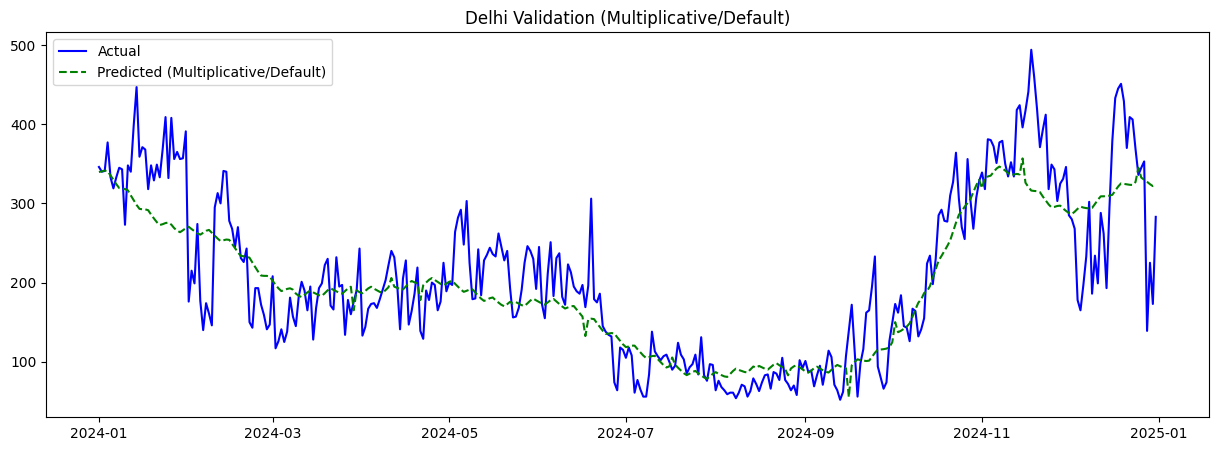

In [23]:
# Cell 3B: Test Multiplicative Seasonality, Default Priors

logging.info("--- Testing Config: Multiplicative, Default Priors ---")
model_multiplicative_default = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative', # CHANGED
    changepoint_prior_scale=0.05,    # Prophet default
    seasonality_prior_scale=10.0,    # Prophet default
    holidays_prior_scale=10.0        # Prophet default
)
try: model_multiplicative_default.add_country_holidays(country_name='IN')
except Exception as e: logging.warning(f"Could not add holidays: {e}")

logging.info("Fitting Multiplicative/Default model...")
model_multiplicative_default.fit(train_df)
logging.info("Fitting complete.")

logging.info("Predicting on validation set...")
future_multiplicative_default = model_multiplicative_default.make_future_dataframe(periods=len(validation_df))
future_multiplicative_default = future_multiplicative_default[future_multiplicative_default['ds'] >= split_date]
forecast_multiplicative_default = model_multiplicative_default.predict(future_multiplicative_default)

logging.info("Evaluating Multiplicative/Default model...")
eval_df_md = pd.merge(validation_df, forecast_multiplicative_default[['ds', 'yhat']], on='ds', how='inner')
mae_md = mean_absolute_error(eval_df_md['y'], eval_df_md['yhat'])
rmse_md = np.sqrt(mean_squared_error(eval_df_md['y'], eval_df_md['yhat']))
y_true_md = eval_df_md['y']
y_pred_md = eval_df_md['yhat']
non_zero_mask_md = np.abs(y_true_md) > 1e-6
mape_md = mean_absolute_percentage_error(y_true_md[non_zero_mask_md], y_pred_md[non_zero_mask_md]) * 100 if non_zero_mask_md.any() else np.nan

print("\n--- Results: Multiplicative, Default Priors ---")
print(f"MAE: {mae_md:.2f}, RMSE: {rmse_md:.2f}, MAPE: {mape_md:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(eval_df_md['ds'], eval_df_md['y'], label='Actual', color='blue')
plt.plot(eval_df_md['ds'], eval_df_md['yhat'], label='Predicted (Multiplicative/Default)', color='green', linestyle='--')
plt.title(f'{TARGET_CITY} Validation (Multiplicative/Default)')
plt.legend()
plt.show()

In [5]:
# Cell 4: Prediction Function with Real-time Adjustment (Corrected)

def predict_aqi_adjusted(target_city, trained_model, days_ahead=5, apply_residual_correction=True, last_known_aqi=None, last_known_aqi_date=None):
    """
    Generates AQI forecast for the next few days, optionally adjusting
    based on the latest actual AQI.

    Args:
        target_city (str): The city name (e.g., 'Delhi'). Used for API call if adjusting.
        trained_model (Prophet): The pre-trained Prophet model for the city.
        days_ahead (int): Number of days to forecast (default 5).
        apply_residual_correction (bool): Whether to fetch/use current AQI for residual correction.
        last_known_aqi (float, optional): The most recent actual AQI value. If provided,
                                          residual correction uses this instead of calling API.
        last_known_aqi_date (pd.Timestamp, optional): The date for last_known_aqi. If not provided,
                                                     the model's last training date is used for correction calc.

    Returns:
        pd.DataFrame: DataFrame with 'ds' and 'yhat_adjusted' (forecasted AQI)
                      for the requested future days. Returns None on failure.
                      Includes original 'yhat', uncertainty bounds, and 'residual' if correction applied.
    """
    logging.info(f"Generating {days_ahead}-day forecast for {target_city}...")

    # 1. Create future dates dataframe starting AFTER the model's last training date
    # The model knows its training data range internally.
    try:
        future_dates_df = trained_model.make_future_dataframe(periods=days_ahead, include_history=False)
        logging.info(f"Predicting for dates: {future_dates_df['ds'].min().date()} to {future_dates_df['ds'].max().date()}")
    except Exception as e:
         logging.error(f"Error creating future dataframe with make_future_dataframe: {e}")
         return None

    if future_dates_df.empty:
        logging.error("make_future_dataframe returned empty dataframe. Check days_ahead.")
        return None

    # --- Placeholder for adding FUTURE regressors ---
    # If the model was trained with external regressors:
    # Add the corresponding future values for those regressors to future_dates_df here.
    # --- End Placeholder ---

    # 2. Generate initial forecast from the trained model
    try:
        forecast = trained_model.predict(future_dates_df)
        forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    except Exception as e:
        logging.error(f"Failed to generate initial forecast: {e}")
        return None

    # Initialize adjusted forecast same as original
    forecast['yhat_adjusted'] = forecast['yhat'].copy()
    forecast['residual'] = 0.0

    # 3. Apply Residual Correction (Optional)
    actual_today = None # Initialize variable to store the actual value used for correction
    if apply_residual_correction:
        logging.info(f"Attempting residual correction for {target_city}...")
        try:
            # Determine the date to use for the correction calculation ("today")
            if last_known_aqi_date:
                today_ds = pd.Timestamp(last_known_aqi_date).normalize() # Use provided date
                logging.info(f"Using provided date as 'today' for correction: {today_ds.date()}")
            else:
                 # Default to the last date the model was trained on
                 today_ds = trained_model.history_dates.max()
                 logging.info(f"Using model's last training date as 'today' for correction: {today_ds.date()}")

            # Predict what the model *thought* AQI was for "today"
            today_df = pd.DataFrame({'ds': [today_ds]})
            # --- Placeholder for adding regressors for "today" ---
            # If using regressors, add the known values for today_ds to today_df
            # --- End Placeholder ---
            today_forecast = trained_model.predict(today_df)

            if not today_forecast.empty:
                predicted_today = today_forecast['yhat'].iloc[0]
                logging.info(f"Model's prediction for {today_ds.date()}: {predicted_today:.2f}")

                # Get the "actual" AQI for "today"
                if last_known_aqi is not None:
                     actual_today = float(last_known_aqi)
                     logging.info(f"Using provided last_known_aqi for {today_ds.date()}: {actual_today}")
                else:
                    # Fetch from API if specific value wasn't provided
                    logging.info(f"Fetching current AQI from API for {target_city} to use as proxy for {today_ds.date()}...")
                    current_aqi_info = get_current_aqi_for_city(target_city) # Calls API
                    if current_aqi_info and 'aqi' in current_aqi_info:
                        actual_today = float(current_aqi_info['aqi'])
                        logging.info(f"Actual current AQI from API: {actual_today}")
                    else:
                         logging.warning(f"Could not get current AQI from API for {target_city}. Skipping residual correction.")

                # If we successfully got an actual value, calculate and apply residual
                if actual_today is not None:
                    residual = actual_today - predicted_today
                    forecast['residual'] = residual
                    logging.info(f"Calculated residual (Actual - Predicted): {residual:.2f}")

                    forecast['yhat_adjusted'] = forecast['yhat'] + residual
                    logging.info(f"Applied residual correction.")

                    # Ensure adjusted forecast doesn't go below zero
                    forecast['yhat_adjusted'] = forecast['yhat_adjusted'].clip(lower=0)
                else:
                     # Ensure reset if actual value couldn't be obtained
                     forecast['residual'] = 0.0
                     forecast['yhat_adjusted'] = forecast['yhat'].copy()

            else:
                 logging.warning(f"Could not generate model prediction for {today_ds.date()}. Skipping residual correction.")
                 forecast['residual'] = 0.0
                 forecast['yhat_adjusted'] = forecast['yhat'].copy()

        except Exception as e:
            logging.error(f"Error during residual correction: {e}. Proceeding without correction.", exc_info=True)
            forecast['residual'] = 0.0
            forecast['yhat_adjusted'] = forecast['yhat'].copy()
    else:
        logging.info("Residual correction not applied as per request.")

    # 4. Return relevant columns
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'residual', 'yhat_adjusted']]


# --- Test the Prediction Function ---
# Ensure the necessary variables (TARGET_CITY, model) exist from previous cells
print("\n--- Testing Prediction Function ---")
days_to_forecast = 5 # Define how many days ahead we want

# --- Test Case 1: Forecasting WITH Residual Correction (using API) ---
print(f"\n--- Test Case 1: Forecasting {days_to_forecast} days WITH Residual Correction (using API) ---")
test_forecast_adjusted_api = predict_aqi_adjusted(
    target_city=TARGET_CITY,
    trained_model=model,      # Use the model trained in Cell 2
    days_ahead=days_to_forecast,
    apply_residual_correction=True
    # Let the function call the API by not providing last_known_aqi/date
)

if test_forecast_adjusted_api is not None:
    print(f"Adjusted {days_to_forecast}-Day Forecast for {TARGET_CITY} (using API for correction):")
    print(test_forecast_adjusted_api[['ds', 'yhat_adjusted', 'residual', 'yhat']]) # Simplified view
else:
    print(f"Failed to generate adjusted (API) {days_to_forecast}-day forecast for {TARGET_CITY}.")


# --- Test Case 2: Forecasting WITH Residual Correction (providing last known value) ---
# Simulate having a known value for the last training date
last_train_date = model.history_dates.max()
simulated_last_aqi = 290.0 # Example value - replace with a realistic value if desired
print(f"\n--- Test Case 2: Forecasting {days_to_forecast} days WITH Residual Correction (using provided last AQI={simulated_last_aqi} for {last_train_date.date()}) ---")
test_forecast_adjusted_manual = predict_aqi_adjusted(
    target_city=TARGET_CITY,
    trained_model=model,
    days_ahead=days_to_forecast,
    apply_residual_correction=True,
    last_known_aqi=simulated_last_aqi, # Provide the value
    last_known_aqi_date=last_train_date # Provide the date for the value
)
if test_forecast_adjusted_manual is not None:
    print(f"Adjusted {days_to_forecast}-Day Forecast for {TARGET_CITY} (using provided last AQI):")
    print(test_forecast_adjusted_manual[['ds', 'yhat_adjusted', 'residual', 'yhat']])
else:
    print(f"Failed to generate adjusted (manual) {days_to_forecast}-day forecast for {TARGET_CITY}.")


# --- Test Case 3: Forecasting WITHOUT Residual Correction ---
print(f"\n--- Test Case 3: Forecasting {days_to_forecast} days WITHOUT Residual Correction ---")
test_forecast_unadjusted = predict_aqi_adjusted(
    target_city=TARGET_CITY,
    trained_model=model,
    days_ahead=days_to_forecast,
    apply_residual_correction=False
)

if test_forecast_unadjusted is not None:
    print(f"Unadjusted {days_to_forecast}-Day Forecast for {TARGET_CITY}:")
    print(test_forecast_unadjusted[['ds', 'yhat_adjusted', 'residual', 'yhat']])
else:
    print(f"Failed to generate unadjusted {days_to_forecast}-day forecast for {TARGET_CITY}.")

print("\nPrediction function definition and testing complete.")


--- Testing Prediction Function ---

--- Test Case 1: Forecasting 5 days WITH Residual Correction (using API) ---
Adjusted 5-Day Forecast for Delhi (using API for correction):
          ds  yhat_adjusted    residual        yhat
0 2024-01-01     152.903069 -182.966094  335.869164
1 2024-01-02     153.844759 -182.966094  336.810853
2 2024-01-03     154.812376 -182.966094  337.778471
3 2024-01-04     154.353903 -182.966094  337.319997
4 2024-01-05     148.901376 -182.966094  331.867471

--- Test Case 2: Forecasting 5 days WITH Residual Correction (using provided last AQI=290.0 for 2023-12-31) ---
Adjusted 5-Day Forecast for Delhi (using provided last AQI):
          ds  yhat_adjusted   residual        yhat
0 2024-01-01     286.903069 -48.966094  335.869164
1 2024-01-02     287.844759 -48.966094  336.810853
2 2024-01-03     288.812376 -48.966094  337.778471
3 2024-01-04     288.353903 -48.966094  337.319997
4 2024-01-05     282.901376 -48.966094  331.867471

--- Test Case 3: Forecasting 5

In [6]:
# Cell 5: Save the Trained Model

import json
from prophet.serialize import model_to_json
import os
# import joblib # Use if you prefer joblib/pickle over JSON

# --- Define Path for Saved Models ---
# Ensure MODELS_DIR is defined relative to PROJECT_ROOT from Cell 1
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
os.makedirs(MODELS_DIR, exist_ok=True) # Create models/ directory if needed

# Define filename for this specific model (using TARGET_CITY from Cell 1)
# Adding a version indicator is good practice
model_filename_json = f"{TARGET_CITY}_prophet_model_v2.json"
model_path_json = os.path.join(MODELS_DIR, model_filename_json)

# --- Save using Prophet's JSON serialization ---
logging.info(f"Saving IMPROVED Prophet model for {TARGET_CITY} to JSON: {model_path_json}")
try:
    # model_to_json serializes the fitted model object
    with open(model_path_json, 'w') as fout:
        json.dump(model_to_json(model), fout) # Use the 'model' variable from Cell 2
    logging.info("Improved model saved successfully as JSON.")
    print(f"\nImproved model for {TARGET_CITY} saved to: {model_path_json}")
except Exception as e:
    logging.error(f"Error saving improved model as JSON: {e}")
    print(f"\nERROR: Failed to save model for {TARGET_CITY}.")


# --- Alternative: Save using joblib ---
# model_filename_joblib = f"{TARGET_CITY}_prophet_model_v2.joblib"
# model_path_joblib = os.path.join(MODELS_DIR, model_filename_joblib)
# logging.info(f"Saving Improved Prophet model for {TARGET_CITY} using joblib: {model_path_joblib}")
# try:
#     joblib.dump(model, model_path_joblib)
#     logging.info("Improved model saved successfully using joblib.")
#     print(f"\nImproved model for {TARGET_CITY} saved to: {model_path_joblib}")
# except Exception as e:
#     logging.error(f"Error saving improved model using joblib: {e}")


# Reminder about gitignore
print(f"\nReminder: Ensure 'models/{model_filename_json}' or 'models/' is in your .gitignore if you don't want to commit large model files.")


Improved model for Delhi saved to: /Users/apple/Personal_Files/Codes/BreatheEasy/models/Delhi_prophet_model_v2.json

Reminder: Ensure 'models/Delhi_prophet_model_v2.json' or 'models/' is in your .gitignore if you don't want to commit large model files.
